In [ ]:
# description : this program uses a RNN called LSTM
# to predict closing stock price of a corportion using past 60 day stock price

In [ ]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')


In [ ]:
# get the stock quote
val = input("Enter your value: ")
print(val)
today = date.today()
yesterday = today - timedelta(days = 1)
tomorrow = today + timedelta(days = 1)
df = web.DataReader(val , data_source='yahoo', start= '2014-01-01', end= yesterday)
#show the data
df

Enter your value: COST
COST


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,119.300003,117.739998,118.709999,117.809998,1618400.0,99.024254
2014-01-03,118.360001,117.129997,118.209999,117.290001,1293500.0,98.587143
2014-01-06,117.750000,115.889999,117.489998,116.400002,2120200.0,97.839096
2014-01-07,116.559998,115.379997,116.389999,115.860001,2292500.0,97.385201
2014-01-08,116.040001,113.919998,116.040001,114.050003,4600000.0,95.863838
...,...,...,...,...,...,...
2021-04-14,364.850006,362.549988,364.850006,363.170013,1509400.0,363.170013
2021-04-15,369.549988,364.269989,364.880005,368.799988,1850100.0,368.799988
2021-04-16,372.799988,368.579987,369.700012,370.720001,2248300.0,370.720001


In [ ]:
# get the bumber of rows and columns in the dataset
df.shape


(1837, 6)

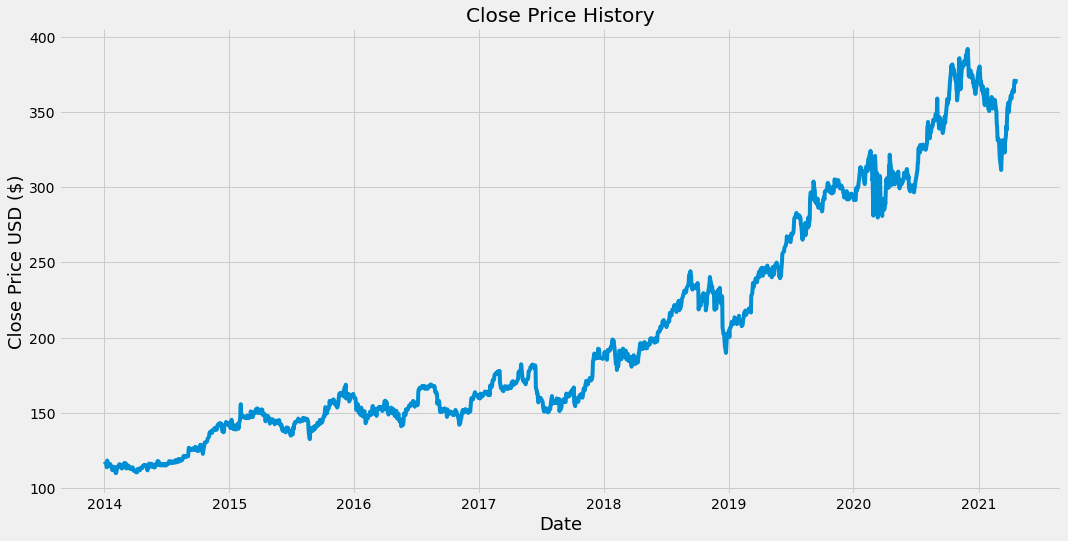

In [ ]:
#visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
#Create a new dataframe with only the 'close'
data = df.filter(['Close'])
# convert the dataframe to a numpy array
dataset = data.values
#get or compute the number of rows to train the model
training_data_len = math.ceil(len(dataset)* .8)


training_data_len

1470

In [ ]:
## Scale the data makes values between zero and one
scaler = MinMaxScaler(feature_range=(0,1))

scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02709612],
       [0.02524948],
       [0.02208886],
       ...,
       [0.92524597],
       [0.92109094],
       [0.92883278]])

In [ ]:
#create the training dataset
#create scaled training data
train_data = scaled_data[0:training_data_len,:]
#split the data into xtrain and ytrain data sets

x_train = []
y_train = []

# appends the next 60 values to the xtrain array
for i in range(120, len(train_data)):
  x_train.append(train_data[i-120:i,0])
  y_train.append(train_data[i, 0])
  #if statement is to visual what is going on!!!
  #y_train is the 61st data point that we are trying to predict
  if i<=61:
    print(x_train)
    print(y_train)
    print()




In [ ]:
#convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
#reshape the x_train dataset
#lstm expects the data to be 3 dimensional
#(samples, timesteps, features)

#currently 2 dimensional
print('shape at 2d')
x_train.shape
#(1543,60)

#(sample size needs to be a variable(x_train.shape[0]), 60 timesteps(x_train.shape[1]), and 1 feature (closing price))
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
print('shape at 3d')
x_train.shape




shape at 2d
shape at 3d


(1350, 120, 1)

In [ ]:
#NEW PROGRAMS MODEL TRAINING CODE
# THIS MODEL DOES BETTER THAN THE OTHER MODEL
#build the lstm model
model = Sequential()
model.add(LSTM(50,return_sequences=True, input_shape= (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [ ]:
#compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
#train the model
#COULD MAYBE PLAY AROUND WITH BATCH SIZE AND EPOCHS
#OTHER MODEL USED BATCHSIZE = 100 , EPOCHS = 32
model.fit(x_train,y_train,batch_size=1, epochs=1)

1350/1350 [==============================] - 56s 39ms/step - loss: 0.0022


In [ ]:
#create the testing dataset
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 120: , :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(120,len(test_data)):
  x_test.append(test_data[i-120:i, 0])

In [ ]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
#reshape the data (samples , timesteps, features) --- like before
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [ ]:
#get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#changing the values back to 2d


In [ ]:
# get the root mean squared error (RSME)
#closer to zero the more accurate
rmse = np.sqrt(np.mean(predictions - y_test) **2)
rmse

6.213006458750213

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


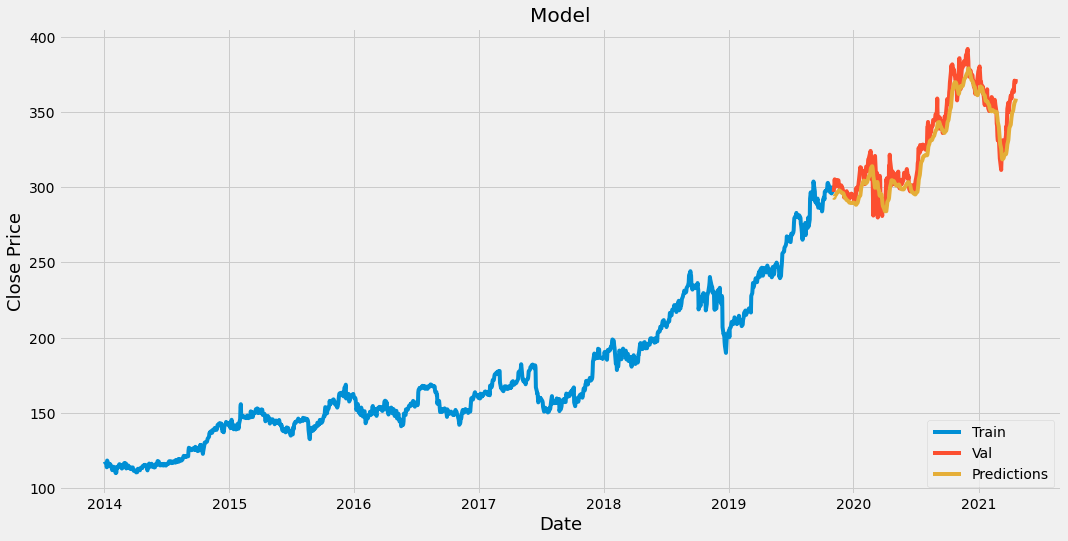

In [ ]:
#plot the data 
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

#visualize the data

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Val','Predictions'], loc='lower right')
plt.show()


In [ ]:
# show the valid and the predicted prices
valid 

,Close,Predictions
Date,,
2019-11-04,296.820007,293.113739
2019-11-05,299.179993,292.893829
2019-11-06,301.570007,292.944275
2019-11-07,305.209991,293.355652
2019-11-08,302.619995,294.262268
...,...,...
2021-04-14,363.170013,353.783569
2021-04-15,368.799988,354.788757
2021-04-16,370.720001,356.066406


In [ ]:
#  THIS BLOCK GETS PREDICTS THE PRICE FOR (today) WITHOUT IT BEING IN THE DATA
# 60 day prediction for tomorrow
# get the quote 
quote = web.DataReader(val, data_source='yahoo', start= '2014-01-01', end = yesterday)
#create a new dataframe
new_df = quote.filter(['Close'])
#get the last 60 day closing price values and convert the dataframe to an array
last_120_days = new_df[-120:].values
#scale the data to be values between 0 and 1
last_120_days_scaled = scaler.transform(last_120_days)
#create and empty list
X_test = []
y_test = last_120_days
#Append the last 60 days
X_test.append(last_120_days_scaled)

#convert the X_test dataset to a numpy array
X_test = np.array(X_test)

#reshape
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

#get predicted scale price
pred_price = model.predict(X_test)

#undo scaling
pred_price = scaler.inverse_transform(pred_price)
print("predicted price for tomorrow")
print(pred_price)


quote2 = web.DataReader(val, data_source='yahoo', start= today, end= today)
print(quote2['Close'])



predicted price for tomorrow
[[360.0767]]
Date
2021-04-21    373.371704
Name: Close, dtype: float64
